In [1]:
from qdb import QdbApi

In [17]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from IPython.display import display

class TechIndicator(object):
    """计算技术指标"""

    @staticmethod
    def _ema(price: pd.Series, period=None, adjust=False) -> pd.Series:
        """计算EMA(Exponential Moving Average)"""
        return price.ewm(span=period, adjust=adjust).mean()

    @staticmethod
    def macd(price: pd.Series, window_fast=12, window_slow=26, window_sgn=9) -> pd.Series:
        """Moving Average Convergence Divergence (MACD)
        实际返回是MACD_signal，没有计算DIFF(= MACD - MACD_signal)
        """
        price_ema_fast = TechIndicator._ema(price=price, period=window_fast)
        price_ema_slow = TechIndicator._ema(price=price, period=window_slow)
        price_macd = price_ema_fast - price_ema_slow
        price_macd_signal = TechIndicator._ema(price=price_macd, period=window_sgn)
        price_macd_signal.name = f'MACD({window_fast},{window_slow},{window_sgn})'
        return price_macd_signal

def standard_scaler(X: pd.Series, window_size: int=60):
    X_rolling = X.rolling(window_size, min_periods=1)
    mu = X_rolling.mean()
    sigma = X_rolling.std()
    sigma[X.index[0]] = 1
    return (X - mu) / sigma

def cal_win_rate(df):
    df_long = df[df['pos'] == 1].copy()
    df_short = df[df['pos'] == -1].copy()
    print(f'做多胜率：{(df_long["ret"]>0).sum() / len(df_long):.2%}')
    if len(df_short) != 0:
        print(f'做空胜率：{(df_long["ret"]<0).sum() / len(df_long):.2%}')
        df_pos = df[df['pos'] != 0].copy()
        print(f"总胜率：{(df_pos['pos']*df_pos['ret'] > 0).sum() / len(df_pos):.2%}")

def cal_period_perf_indicator(df):
    """
    计算区间业绩指标(高级版)
    Input
        df: 价格或净值序列，DataFrame, index是datetime.date，每列是一只基金
    Output
        ['AnnRet1', 'AnnRet2', 'AnnVol', 'SR', 'MaxDD', 'Calmar'] 
    """
    assert type(df)==pd.DataFrame
    assert type(df.index[0])==dt.date

    indicators = ['AnnRet', 'AnnRet_Simple', 'AnnVol', 'SR', 'MaxDD', 'Calmar', 'DD']
    res = pd.DataFrame(index=df.columns, columns=indicators)
    date_ordinal = pd.Series([dt.date.toordinal(e) for e in df.index])
    time_diff = date_ordinal - date_ordinal.shift(1) # 相对上一次净值的日期间隔
    for col in df: 
        p = df[col] # 单个资产价格或净值序列, pd.Series
        dd = (p/p.cummax() - 1)[-1] # 当前回撤
        r = p.pct_change() # 涨幅
        p.dropna(inplace=True)
        annret = (p[-1] / p[0]) ** (365/(p.index[-1]-p.index[0]).days) - 1 # 复利年化收益
        
        r1 = r.values / time_diff # 日均收益
        rb = df[df.columns[0]].pct_change().values / time_diff # 基准日均收益
        annret1 = np.nanmean(r1) * 365 # 单利年化收益
        r2 = r.values / np.sqrt(time_diff) # 波动率调整后涨幅   
        annvol = np.nanstd(r2) * np.sqrt(365) # 年化波动率
        sr = (annret - 0.025) / annvol # 夏普比率
        mdd = np.min(p/p.cummax() - 1) # 最大回撤
        calmar = annret / -mdd
        res.loc[col] = [annret, annret1, annvol, sr, mdd, calmar, dd]
    return res

class StkTiming(object):
    """股票择时框架"""

    def __init__(self, q):
        self._q = q

    def get_stk_price(self, stk_id=None, start_date=None, end_date=None):
        assert stk_id, 'stk_id不可以为空'
        stk_info = self._q.get_stk_list(stk_ids=stk_id)
        display(stk_info)
        stk_info = stk_info.squeeze()
        start_date = stk_info['list_date'] if start_date is None else start_date
        stk_name_ = stk_info['stk_name']
        stk_daily_ = self._q.get_stk_daily(stk_ids=stk_id, start_date=start_date, end_date=end_date).set_index('date')
        stk_daily_ = stk_daily_.drop('stk_id', axis=1)
        stk_adj_price = stk_daily_['close'] * stk_daily_['cumadj']
        stk_adj_price.name = 'Close (adj)'
        # 展示复权收盘价
        fig, ax = plt.subplots(figsize=(16, 5))
        stk_adj_price.plot(ax=ax)
        ax.grid('on')
        ax.set_title(f'{stk_name_} {stk_adj_price.name}')
        fig.show()
        self.stk_name_ = stk_name_
        self.stk_daily_ = stk_daily_
        self.stk_adj_price = stk_adj_price

    def add_signal(self, signal_name=None, *args, **kwargs):
        assert signal_name in ['macd']
        stk_adj_price = self.stk_adj_price
        signal = getattr(TechIndicator, signal_name)(stk_adj_price, *args, **kwargs)
        signal = standard_scaler(signal)
        # 与复权收盘价合并作图
        fig, ax = plt.subplots(figsize=(16, 5))
        ax.grid()
        stk_adj_price.plot(ax=ax)
        ax.legend(loc="upper left")
        ax_twinx = ax.twinx()
        signal.plot(ax=ax_twinx, color="#d8a373")
        ax_twinx.legend(loc="upper right")
        ax.set_title(f'{self.stk_name_} -- {signal.name}')
        self.signal = signal
        fig.show()

    def backtest(self, pos_rule='long_only', long_threshold=1, short_threshold=-1):
        assert pos_rule in ['long_only', 'long_short'], '满足的策略规则：long_only, long_short'
        df = self.signal.to_frame()
        signal_name = self.signal.name
        price_name = self.stk_adj_price.name
        df[price_name] = self.stk_adj_price
        df['pos'] = np.nan
        if pos_rule == 'long_only':
            df['pos'] = [1 if e>long_threshold else 0 for e in df[signal_name].shift(1)]
        elif pos_rule == 'long_short':
            df['pos'] = [1 if e>long_threshold else -1 if e<short_threshold else 0 for e in df[signal_name].shift(1)]

        df['ret'] = df[price_name].pct_change()
        df.loc[df.index[0], 'ret'] = 0
        df['stgy_ret'] = df['pos'] * df['ret']
        df['stgy'] = (1+df['stgy_ret']).cumprod() * df.loc[df.index[0], price_name]
        
        cal_win_rate(df)
        display(cal_period_perf_indicator(df[[price_name, 'stgy']].copy()))
        
        # 与复权收盘价合并作图
        fig, ax = plt.subplots(figsize=(16, 5))
        df[[price_name, 'stgy']].plot(ax=ax, grid=True)
        df['pos'].plot(ax=ax, grid=True, title='pos')
        # 择时区间
        pos_bool = df['pos'].astype(bool)
        pos_change = pos_bool ^ pos_bool.shift(1)
        pos_change_dates = pos_change[pos_change].index.tolist()
        if len(pos_change_dates) % 2 == 1:
            pos_change_dates.append(df.index[-1])
        pos_open_dates = pos_change_dates[::2]
        pos_close_dates = pos_change_dates[1::2]
        ymin, ymax = ax.get_ylim()
        for open_date, close_date in zip(pos_open_dates, pos_close_dates):
            color = 'blue' if df.loc[open_date, 'pos'] == 1 else 'green'
            ax.fill_between(
                [open_date, close_date], 
                ymin, ymax,
                color=color, alpha=0.2)
        ax.set_title(f'{self.stk_name_} -- {signal_name}')
        fig.show()
        self.backtest_df_ = df

成功连接数据库：user=read_only)
成功连接Arctic：user=read_only)
更新了缓存数据：stk_list


,sec_code,stk_name,company_name,list_date,delist_date,board,exch,city,sw_industry_name,sw_industry_code,zx_industry_name,zx_industry_code,backdoor,backdoor_date,update_time,update_note
stk_id,,,,,,,,,,,,,,,,
300750.SZ,300750,宁德时代,宁德时代新能源科技股份有限公司,2018-06-11,None,创业板,深圳,宁德市,电气设备,电源设备,电力设备及新能源,新能源动力系统,0.0,None,2020-04-24 13:45:11,None


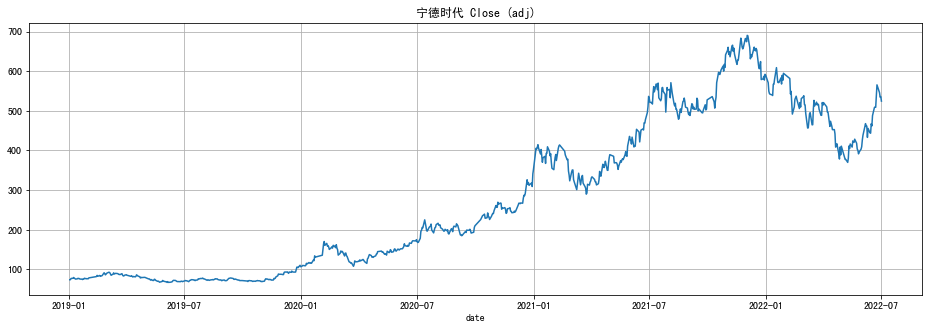

In [18]:
q = QdbApi()
stk_timing = StkTiming(q)
stk_timing.get_stk_price(stk_id='300750.SZ', start_date='2019-01-01')

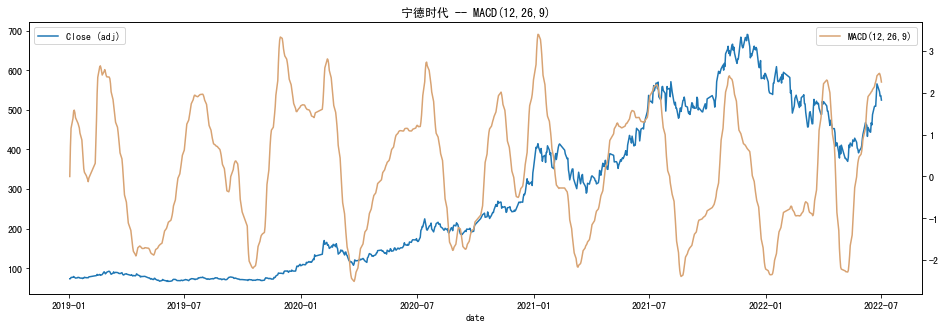

In [19]:
stk_timing.add_signal(signal_name='macd', window_fast=12, window_slow=26, window_sgn=9)

做多胜率：52.55%


,AnnRet,AnnRet_Simple,AnnVol,SR,MaxDD,Calmar,DD
Close (adj),0.753488,0.86523,0.52762,1.380705,-0.46439,1.622533,-0.240349
stgy,0.604703,0.536466,0.357502,1.621539,-0.214386,2.82063,-0.072511


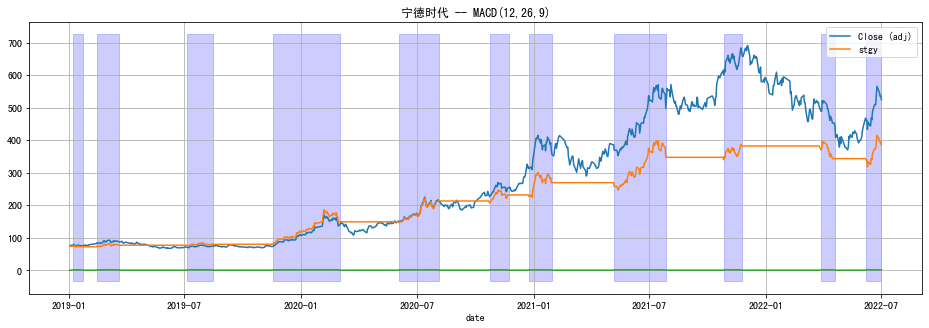

In [20]:
stk_timing.backtest(pos_rule='long_only', long_threshold=1)

做多胜率：52.55%
做空胜率：47.15%
总胜率：52.36%


,AnnRet,AnnRet_Simple,AnnVol,SR,MaxDD,Calmar,DD
Close (adj),0.753488,0.86523,0.52762,1.380705,-0.46439,1.622533,-0.240349
stgy,0.52268,0.377477,0.445277,1.117687,-0.306547,1.705055,-0.159787


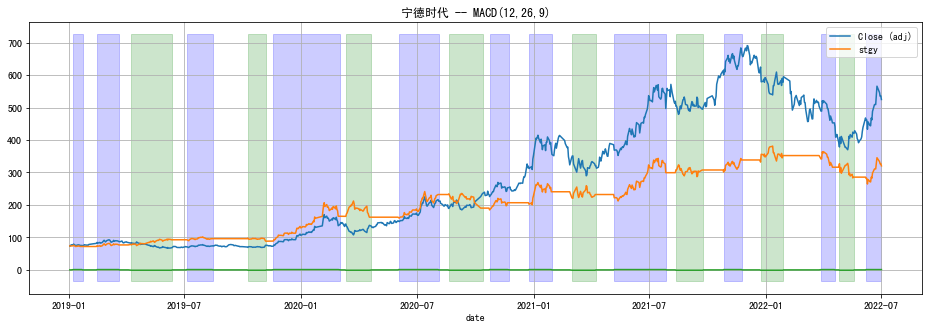

In [21]:
stk_timing.backtest(pos_rule='long_short')